In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
from modules.prepare_and_train_IGP import Multi_Variational_IGP
from modules.prepare_data import *
import yaml
import torch
import numpy as np
from torch import Tensor
from util_functions import *

In [2]:
def load_model_and_likelihoods(multi_variational_igp, filename):
    state_dicts = torch.load(filename)
    for model, state_dict in zip(multi_variational_igp.models, state_dicts['models']):
        model.load_state_dict(state_dict)
    for likelihood, state_dict in zip(multi_variational_igp.likelihoods, state_dicts['likelihoods']):
        likelihood.load_state_dict(state_dict)

## Load in model

In [3]:
with open('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/configs/spatiotemp_IGP_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

MultiIGP = Multi_Variational_IGP(
        num_models = config['n_outputs'],
        inducing_points = Tensor(np.linspace(config['init_inducing_input_LB'], config['init_inducing_input_UB'], config['n_inducing_input']).reshape(-1, 1)), 
        init_likelihood_raw_noise = config['init_likelihood_raw_noise'],
        kernel_type = config['kernel_type'],
        learn_inducing_locations = config["learn_inducing_locations"]
    )

load_model_and_likelihoods(MultiIGP, config['model_and_likelihood_path'])

## Load in data

In [4]:
if config['dataset_type'] == 'spatio_temporal_data':
        data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, _, train_sample_idx_ls, test_sample_idx_ls = prepare_spatio_temp_data(config)

In [5]:
result_dict = predict_and_evaluate_igp(MultiIGP,
                            config,
                            data_inputs, 
                            data_Y_squeezed, 
                            ls_of_ls_train_input, 
                            ls_of_ls_test_input, 
                            train_sample_idx_ls, 
                            test_sample_idx_ls,
                            n_points4visualization=500
                            )

print('#######' * 10)
print('Global Train RMSE', (result_dict["train_error_square_sum"] / result_dict["train_error_length"]).sqrt())
print('Global Test RMSE', (result_dict["test_error_square_sum"] / result_dict["test_error_length"]).sqrt())
print('Global Train NLL', result_dict["train_nll_sum"] / result_dict["train_error_length"])
print('Global Test NLL', result_dict["test_nll_sum"] / result_dict["test_error_length"])

--------------------------------------------------
0th Model Train RMSE:  tensor(0.4168)
0th Model Test RMSE:  tensor(0.4201)
0th Model Train NLL:  tensor(0.2291)
0th Model Test NLL:  tensor(0.3692)
--------------------------------------------------
1th Model Train RMSE:  tensor(0.5230)
1th Model Test RMSE:  tensor(0.5427)
1th Model Train NLL:  tensor(0.4893)
1th Model Test NLL:  tensor(0.6049)
--------------------------------------------------
2th Model Train RMSE:  tensor(0.3527)
2th Model Test RMSE:  tensor(0.3751)
2th Model Train NLL:  tensor(0.3254)
2th Model Test NLL:  tensor(0.3742)
--------------------------------------------------
3th Model Train RMSE:  tensor(0.4549)
3th Model Test RMSE:  tensor(0.5152)
3th Model Train NLL:  tensor(0.5760)
3th Model Test NLL:  tensor(0.7599)
--------------------------------------------------
4th Model Train RMSE:  tensor(0.4509)
4th Model Test RMSE:  tensor(0.3612)
4th Model Train NLL:  tensor(0.0053)
4th Model Test NLL:  tensor(0.1932)
-----

# Plot

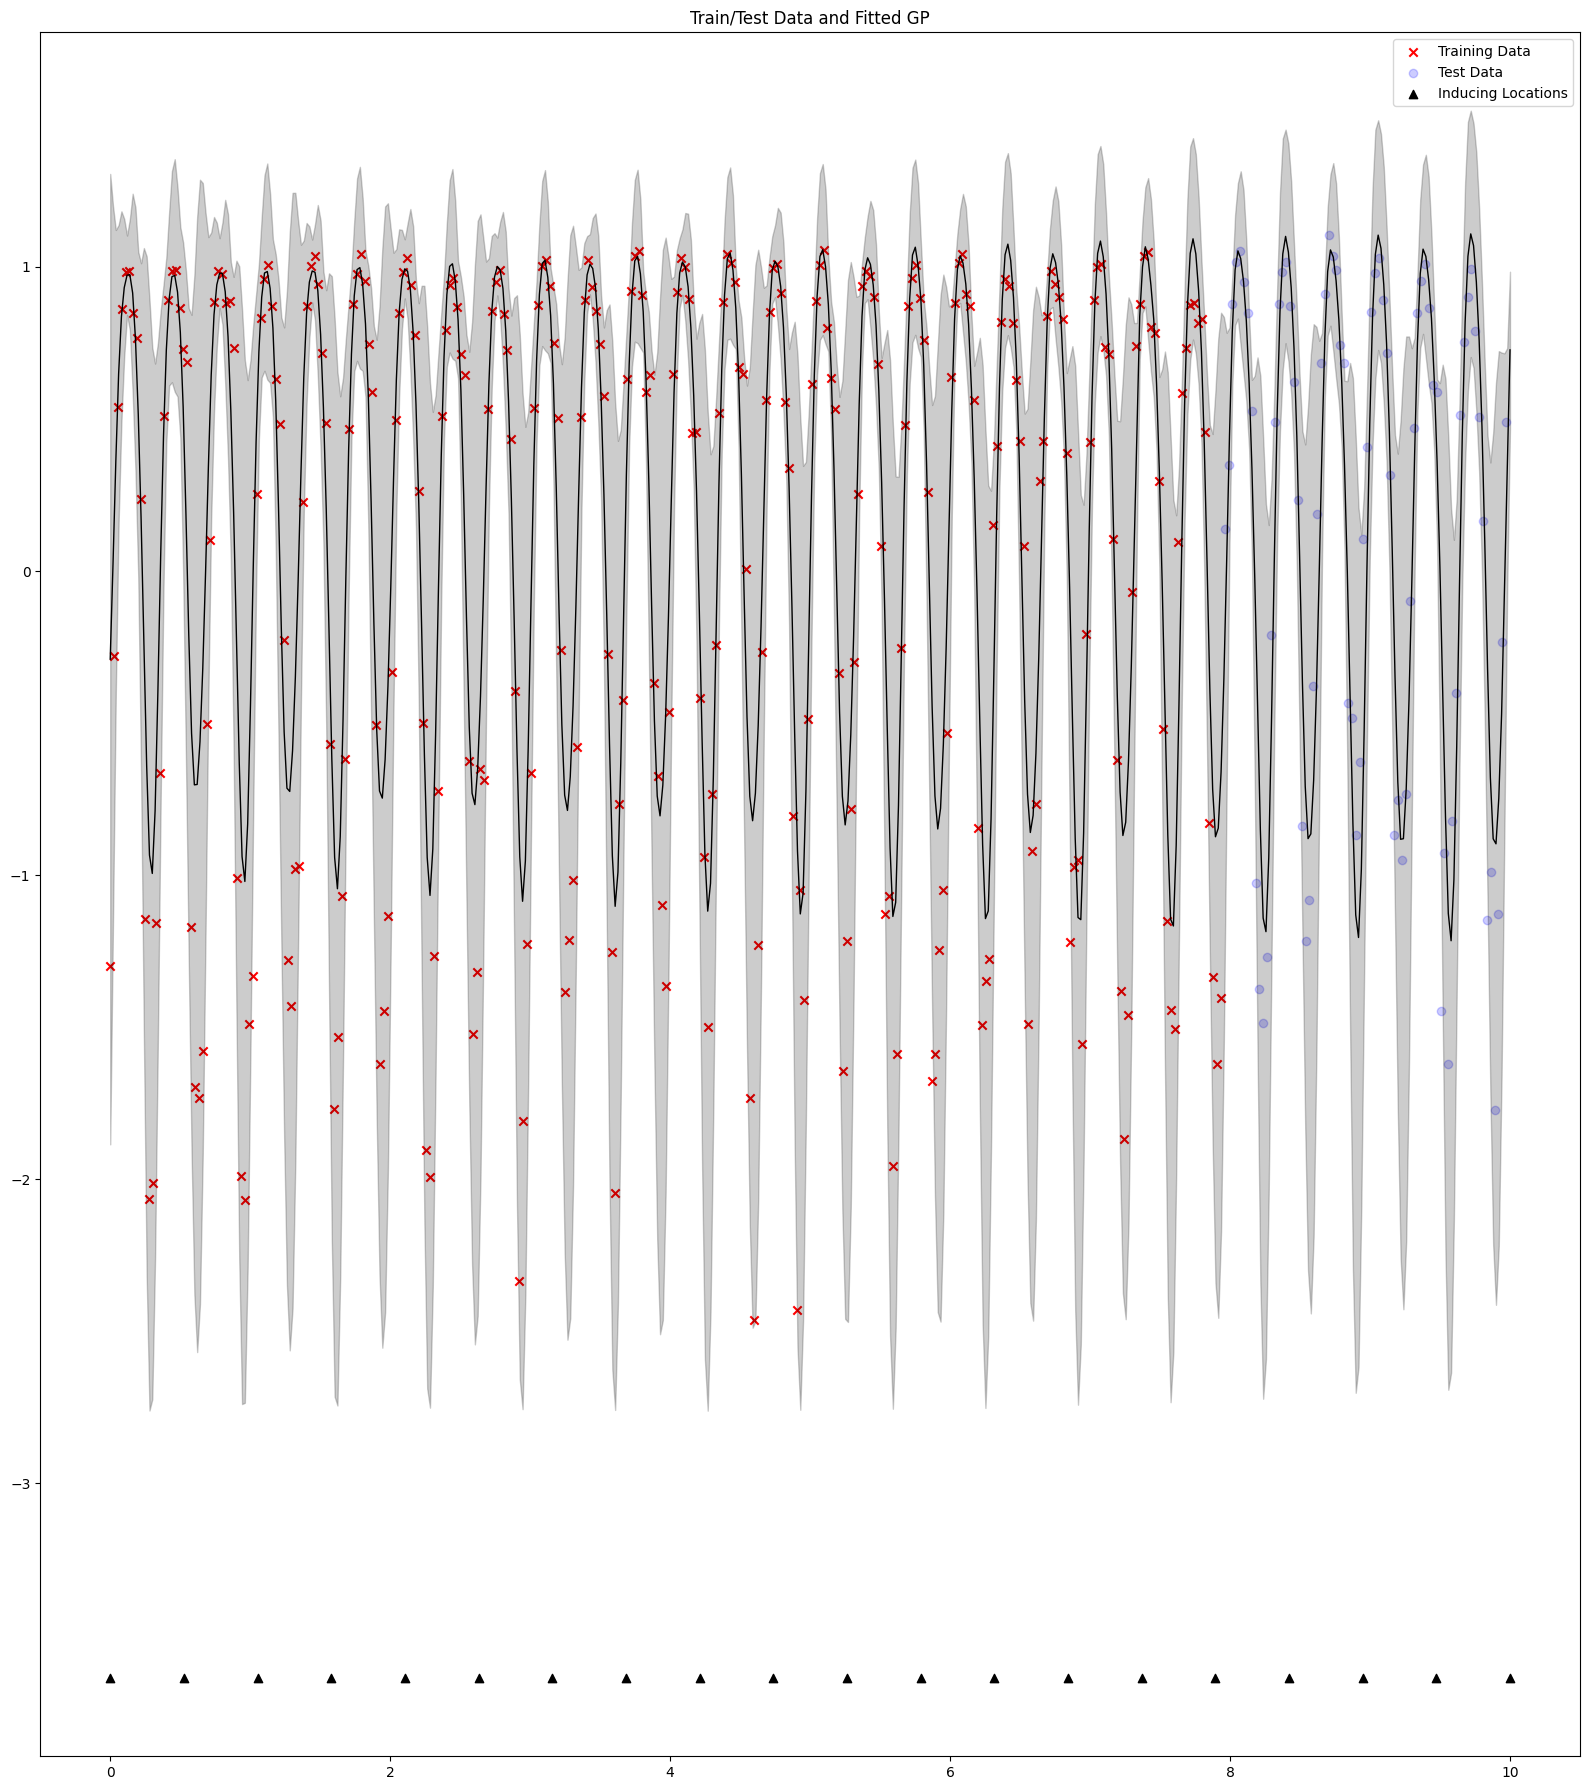

In [8]:
picked_index = 4

plot_traindata_testdata_fittedgp(train_X=result_dict['list_train_X'][picked_index], 
                                 train_Y=result_dict['list_train_Y'][picked_index], 
                                 test_X=result_dict['list_test_X'][picked_index], 
                                 test_Y=result_dict['list_test_Y'][picked_index], 
                                 gp_X=result_dict['tensor_inputs4visualization'], 
                                 gp_pred_mean=result_dict['list_output_dist4visual'][picked_index].loc.detach(), 
                                 gp_pred_std=result_dict['list_output_dist4visual'][picked_index].stddev.detach(), 
                                 inducing_points_X=MultiIGP.get_model(picked_index).variational_strategy.inducing_points.detach(), 
                                 n_inducing_C=config['n_inducing_input']) # NOTE: input is C not X